# Adaptive remeshing technique - Applied for fracture mechanis

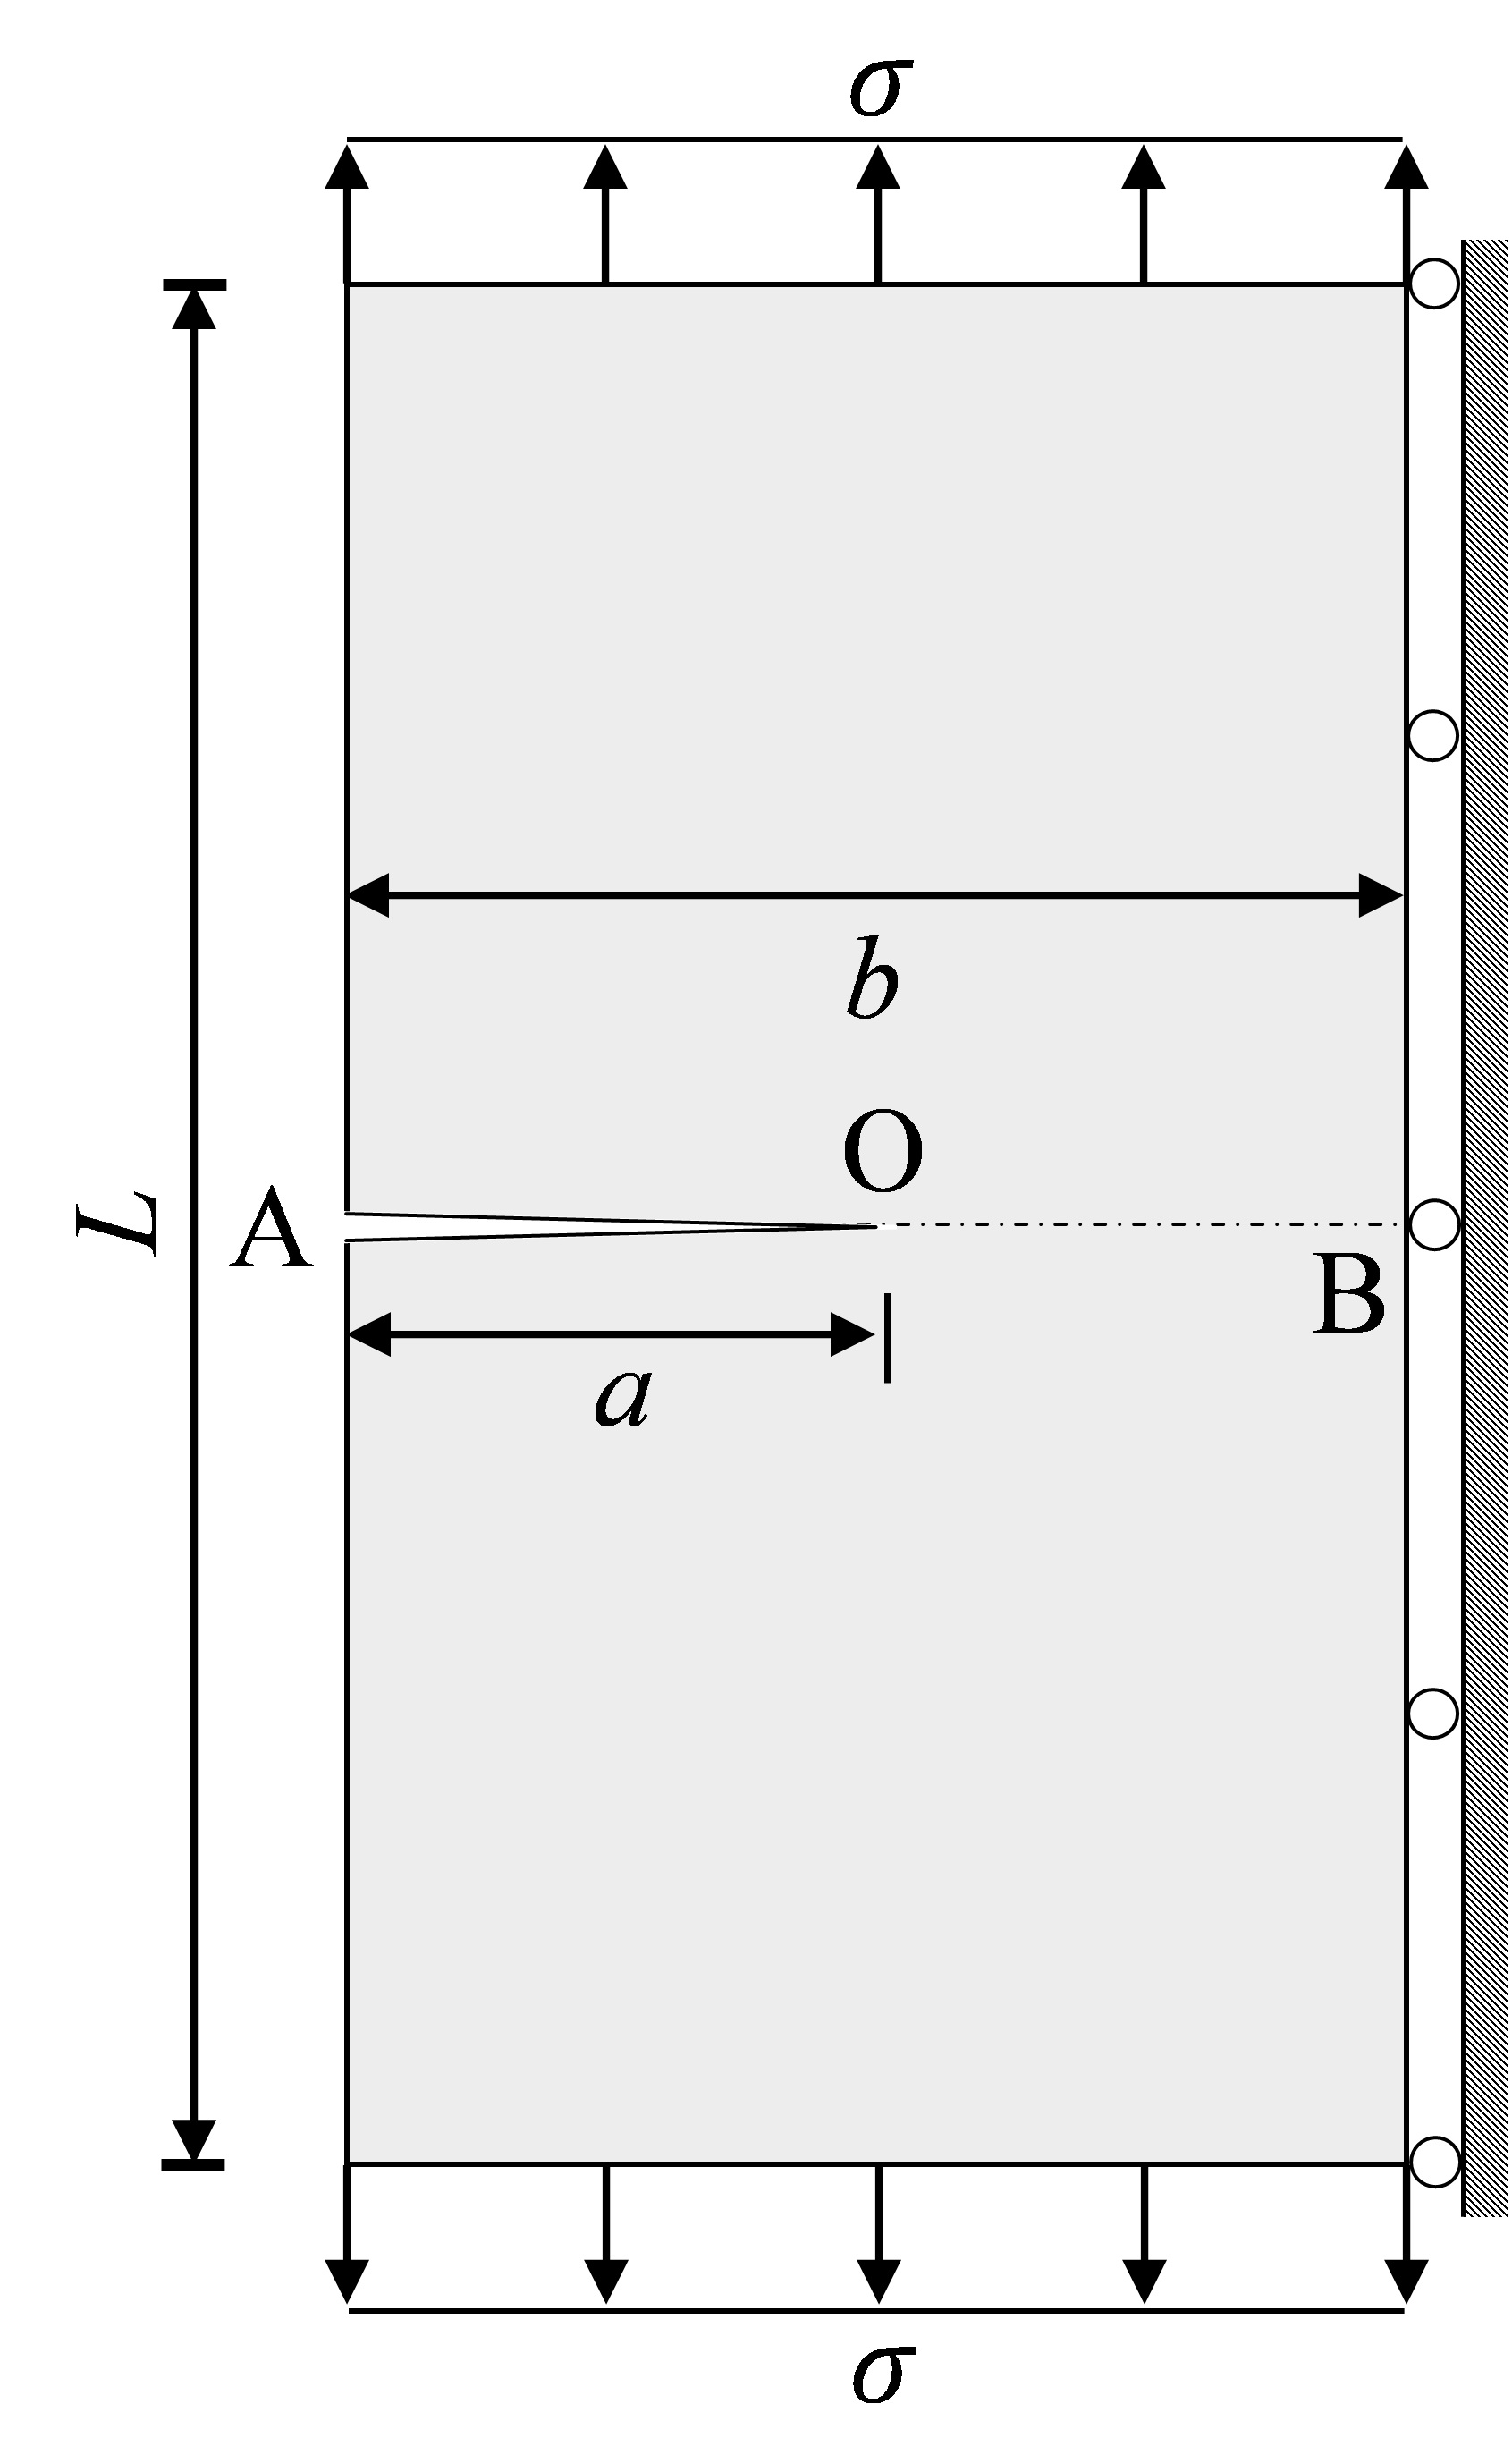

In [1]:
from IPython.display import Image
Image(filename="ModeEdgeCrack.jpg", width = 340, height = 550)

Starting by importing some modules

In [2]:
from IPython import get_ipython
get_ipython().magic('reset -sf') 
import math
import numpy as np
import numpy.matlib
import meshing
import Grid
import auxiliary
import FEM
import plot
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'scipy'

Define a grid and Setup model

In [3]:
aux = auxiliary.AuxiFu()
discre = FEM.Discretization()
boucon = FEM.SetupModel()
solution = FEM.PostProcessing()
young = 1*10**9
poisson = 0.3
thick = 0.01
material = young/(1-poisson**2)*np.array(([[1,poisson,0],
                                    [poisson,1,0],
                                    [0,0,(1-poisson)/2]]))*thick
k = (3 - poisson)/(1 + poisson)
sig = 100000
lx, ly = 1, 1 # lx = b; ly = L
nx, ny = 8, 8 # mesh size
dc = 0.00001 # amplitude of initial fracture 
p, t, nodaro, tipcra, moucra, roscra, nodcra, nodmid = meshing.edgecrack(lx, ly, nx, ny, dc)
numtip = 1
rm = Grid.ReMesh( p, t, tipcra, moucra, roscra, nodcra, nodaro, dc )
crapro = np.zeros((numtip)) == 0
tipava = np.zeros((numtip)) == 0
error = np.zeros((t.shape[0]))
N = 5

## Main program

In [5]:
for step in range(N):
    p, t, moucra, roscra = rm.quaterelement( tipava, crapro, 0 )
    p6, t6, qpe = meshing.t3tot6(tipava, p, t, tipcra)
    dirdof, dirval, neudof, neuval = boucon.edgcraextension(p6, t6, nodaro, nodmid, sig)
    lefhs = discre.stiffness( p6, t6, material, qpe) 
    righs = discre.loadsegment( p6, neudof, neuval)
    disp = solution.solver(lefhs,righs,dirdof,dirval, p6.shape[0]*2)
    Gi, ki, keq, craang = solution.SIF(tipava, p6, t6, numtip, disp, young, poisson, k, qpe )
    Sigxxi,Sigyyi,Sigxyi,error = solution.stresses(p6, t6, disp, material, qpe)
    Ene = solution.energy( p6, t6, disp, material, qpe)
    if step < N:
        Sigxxi,Sigyyi,Sigxyi,error = solution.stresses(p6, t6, disp, material, qpe)
        parame = [Ene*young/(sig**2*lx**2)*thick, ki[0][0]/(sig*np.sqrt(math.pi*lx/2))*thick, max(error)[0]]
        fig, grid = plt.subplots()
        plot.trisurf2d(fig, grid, p6, t6, eleind = 0, nodind = 0, line = [], point = [], parame = parame)
        plt.show()
        plt.pause(0.0001)
        p, t = rm.refinement( tipava, crapro, error, 0, 0, 'based on error' )

ModuleNotFoundError: No module named 'shapely'